In [1]:
import sqlite3
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
RT_LIMIT_LOWER = 4340  # RT range in the database
RT_LIMIT_UPPER = 4580
RT_BASE_PEAK_WIDTH_SECS = 30.0  # assumption about base peak width in RT
MS1_CE = 10

In [3]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
ALLPEPTIDES_FILENAME = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/allPeptides.txt'
# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [4]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [5]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
ms2_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy <> {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [6]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [7]:
ms2_frame_properties_df.head()

,frame_id,retention_time_secs
0,40408,4340.019894
1,40409,4340.127084
2,40410,4340.233855
3,40412,4340.446655
4,40413,4340.554812


In [8]:
ms1_frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
ms1_frame_delay

1.1810854877303427

In [9]:
len(ms1_frame_properties_df)

203

In [10]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [11]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [12]:
# add-in the retention time for the isolation windows and filter out the window not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)
isolation_window_df['rt_lower'] = isolation_window_df.retention_time_secs - RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['rt_upper'] = isolation_window_df.retention_time_secs + RT_BASE_PEAK_WIDTH_SECS

In [13]:
# filter out isolation windows that don't fit in the database subset we have loaded
isolation_window_df = isolation_window_df[(isolation_window_df.rt_lower >= RT_LIMIT_LOWER) & (isolation_window_df.rt_upper <= RT_LIMIT_UPPER)]

In [14]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,rt_lower,rt_upper
315657,40688,219,244,1106.675230,3.0,148941,4370.101926,1105.175230,1108.175230,4340.101926,4400.101926
315658,40688,287,312,987.488407,3.0,148938,4370.101926,985.988407,988.988407,4340.101926,4400.101926
315659,40688,344,369,922.491024,3.0,148930,4370.101926,920.991024,923.991024,4340.101926,4400.101926
315660,40688,386,411,884.941548,3.0,148942,4370.101926,883.441548,886.441548,4340.101926,4400.101926
315661,40688,434,459,876.400632,3.0,148943,4370.101926,874.900632,877.900632,4340.101926,4400.101926


Select one of the precursors

In [15]:
print("There are {} precursor isolation windows.".format(len(isolation_window_df)))

There are 17860 precursor isolation windows.


In [555]:
ISOLATION_WINDOW_IDX = 2305
window_df = isolation_window_df.iloc[ISOLATION_WINDOW_IDX]

In [556]:
# PRECURSOR_ID = 154951
# window_df = isolation_window_df[isolation_window_df.Precursor == PRECURSOR_ID].iloc[0]

In [557]:
window_df

Frame                   40905.000000
ScanNumBegin              231.000000
ScanNumEnd                256.000000
IsolationMz              1056.147912
IsolationWidth              3.000000
Precursor              150185.000000
retention_time_secs      4393.467107
mz_lower                 1054.647912
mz_upper                 1057.647912
rt_lower                 4363.467107
rt_upper                 4423.467107
Name: 317962, dtype: float64

In [558]:
mz_lower = window_df.mz_lower
mz_upper = window_df.mz_upper
scan_width = int(window_df.ScanNumEnd - window_df.ScanNumBegin)
scan_lower = int(window_df.ScanNumBegin - scan_width)
scan_upper = int(window_df.ScanNumEnd + scan_width)
rt_lower = window_df.rt_lower
rt_upper = window_df.rt_upper
precursor_id = int(window_df.Precursor)

In [559]:
# get the ms1 frame IDs
ms1_frame_ids = tuple(ms1_frame_properties_df.astype(int).values[:,0])


In [560]:
# load the cube's raw ms1 points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(mz_lower, mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [561]:
len(raw_points_df)

8826

In [562]:
raw_points_df.intensity.max()

358

In [563]:
raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,40631,1054.888304,238,30,4363.985263
1,40631,1054.919032,255,103,4363.985263
2,40631,1054.924153,273,80,4363.985263
3,40631,1054.975367,256,35,4363.985263
4,40631,1054.980489,270,43,4363.985263


In [564]:
MZ_MIN = mz_lower
MZ_MAX = mz_upper
MZ_BIN_WIDTH = 0.1

In [565]:
bins = np.arange(start=MZ_MIN, stop=MZ_MAX+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [566]:
bins

array([1054.64791242, 1054.74791242, 1054.84791242, 1054.94791242,
       1055.04791242, 1055.14791242, 1055.24791242, 1055.34791242,
       1055.44791242, 1055.54791242, 1055.64791242, 1055.74791242,
       1055.84791242, 1055.94791242, 1056.04791242, 1056.14791242,
       1056.24791242, 1056.34791242, 1056.44791242, 1056.54791242,
       1056.64791242, 1056.74791242, 1056.84791242, 1056.94791242,
       1057.04791242, 1057.14791242, 1057.24791242, 1057.34791242,
       1057.44791242, 1057.54791242, 1057.64791242])

In [567]:
MZ_BIN_COUNT = len(bins)

In [568]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    mz_values_array[idx] = []


In [569]:
# gather the m/z values into bins
for r in zip(raw_points_df.mz, raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= MZ_MIN) and (mz <= MZ_MAX): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, bins)) # in which bin should this mz go
        mz_values_array[mz_array_idx].append((mz, intensity))

In [570]:
import peakutils

In [571]:
# compute the intensity-weighted m/z centroid and the summed intensity of the bins
peaks = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        peaks.append((mz_centroid,summed_intensity))

In [572]:
peaks

[(1054.6923625177972, 828),
 (1054.7952958391445, 984),
 (1054.9138535547715, 4633),
 (1055.002985779961, 70056),
 (1055.0751153331255, 3065),
 (1055.194736469101, 797),
 (1055.299138374885, 1230),
 (1055.4147788230155, 5571),
 (1055.4989945222435, 112721),
 (1055.5698798142778, 2605),
 (1055.7049209377817, 914),
 (1055.8019092718257, 1186),
 (1055.9153146143265, 3994),
 (1055.9950316586205, 113365),
 (1056.0766373878666, 2340),
 (1056.17839089169, 3336),
 (1056.2900890085814, 1266),
 (1056.4167892610233, 4955),
 (1056.4931748570439, 85363),
 (1056.5711710768135, 2809),
 (1056.7102773997806, 800),
 (1056.8223484655782, 2997),
 (1056.9135297514827, 3531),
 (1056.9901777973673, 53159),
 (1057.0758561290302, 2707),
 (1057.1898434411605, 3213),
 (1057.3000964919318, 1287),
 (1057.4140624678007, 3721),
 (1057.4947449463689, 37935),
 (1057.566051192892, 11892)]

In [573]:
peaks_df = pd.DataFrame(peaks, columns=['mz_centroid','summed_intensity'])

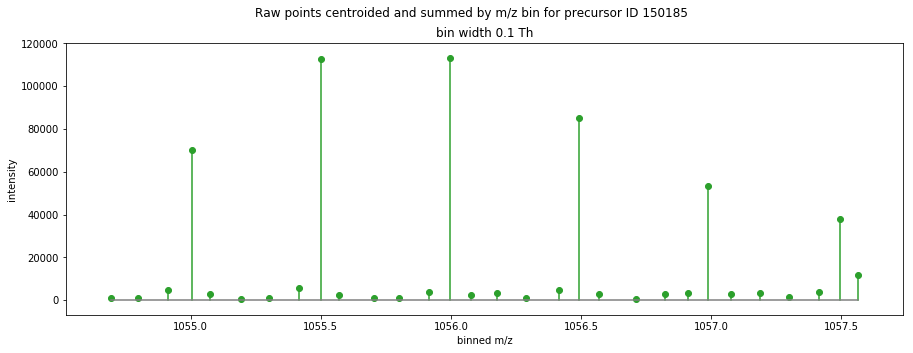

In [574]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(peaks_df.mz_centroid, peaks_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [575]:
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.


In [576]:
from ms_deisotope import deconvolute_peaks, averagine, scoring

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(peaks, averagine=averagine.peptide, charge_range=(1,5), scorer=scoring.MSDeconVFitter(10.0), truncate_after=0.95)


In [577]:
peaks_l = []
for peak in deconvoluted_peaks:
    # discard a monoisotopic peak that has a second isotope with intensity of 1 (rubbish value)
    if ((len(peak.envelope) > 1) and (peak.envelope[1][1] > 1)):
        peaks_l.append((peak.mz, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
        print("{}\n".format(peak))

deconvoluted_peaks_df = pd.DataFrame(peaks_l, columns=['mz','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
deconvoluted_peaks_df['m_plus_h'] = deconvoluted_peaks_df.neutral_mass + PROTON_MASS


DeconvolutedPeak(a_to_a2_ratio=5.295100793831989, area=6549.0, average_mass=1055.6768406996553, charge=1, chosen_for_msms=False, envelope=[(1056.1784, 3336.00), (1057.1898, 3213.00), (1058.1839, 1.00)], full_width_at_half_max=0.01, index=0|5, intensity=6549.0, most_abundant_mass=1055.17111442492, mz=1056.17839089169, neutral_mass=1055.17111442492, score=75.37619853574225, signal_to_noise=3274.5)

DeconvolutedPeak(a_to_a2_ratio=5.295100793831988, area=2553.0, average_mass=1055.7878162834866, charge=1, chosen_for_msms=False, envelope=[(1056.2901, 770.22), (1057.3001, 1287.00), (1058.3023, 1.00)], full_width_at_half_max=0.01, index=1|6, intensity=2057.2182210591604, most_abundant_mass=1056.2928200251617, mz=1056.2967416541317, neutral_mass=1055.2894651873617, score=29.16281003302499, signal_to_noise=1276.5)

DeconvolutedPeak(a_to_a2_ratio=5.295100793831989, area=8676.0, average_mass=1055.908149397642, charge=1, chosen_for_msms=False, envelope=[(1056.4168, 2545.25), (1057.4141, 3721.00), (

In [578]:
deconvoluted_peaks_df

,mz,neutral_mass,intensity,score,SN,m_plus_h
0,1056.178391,1055.171114,6549.000000,75.376199,3274.50,1056.178414
1,1056.296742,1055.289465,2057.218221,29.162810,1276.50,1056.296765
2,1056.416789,1055.409513,6266.247724,59.823147,4338.00,1056.416813
3,1056.562696,1055.555420,13264.114561,38.540877,7350.50,1056.562720
4,1054.693059,2107.371565,3339.000000,58.786073,834.75,2108.378865
5,1054.795296,2107.576039,4666.000000,79.286843,1166.50,2108.583339
6,1054.913101,2107.811650,22684.000000,196.272430,4536.80,2108.818950
7,1055.073283,2108.132012,13526.000000,119.898124,2705.20,2109.139312
8,1055.493354,2108.972156,402543.000000,969.510245,80508.60,2109.979456


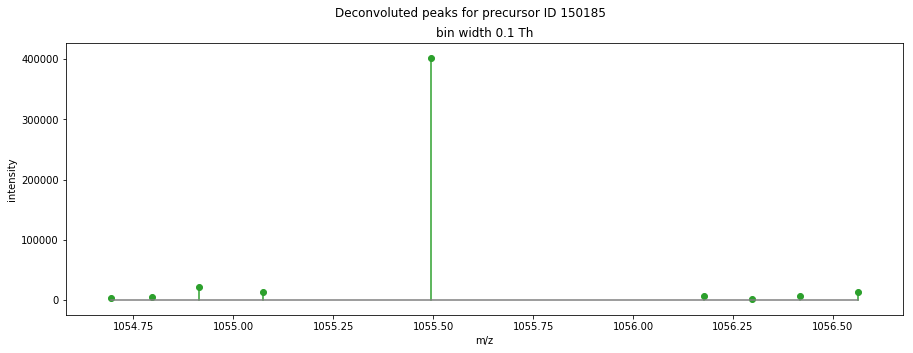

In [579]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

For each monoisotopic peak found, find its apex in RT and mobility

In [624]:
# assume the high score is for the monoisotopic peak
monoisotopic_mz = deconvoluted_peaks_df.iloc[6].mz

In [625]:
monoisotopic_mz

1054.9131014041154

Get the raw points for the monoisotopic peak

In [626]:
MZ_TOLERANCE_PPM = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [627]:
monoisotopic_mz_ppm_tolerance = monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100
monoisotopic_mz_lower = monoisotopic_mz - monoisotopic_mz_ppm_tolerance
monoisotopic_mz_upper = monoisotopic_mz + monoisotopic_mz_ppm_tolerance

In [628]:
monoisotopic_raw_points_df = raw_points_df[(raw_points_df.mz >= monoisotopic_mz_lower) & (raw_points_df.mz <= monoisotopic_mz_upper)]

In [629]:
monoisotopic_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
1,40631,1054.919032,255,103,4363.985263
2,40631,1054.924153,273,80,4363.985263
178,40642,1054.913910,278,67,4365.164748
537,40664,1054.913910,279,48,4367.530406
967,40697,1054.919032,263,57,4371.067913


Collapsing the summed points onto the RT dimension

In [630]:
rt_df = monoisotopic_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()

In [631]:
peaks_idx = peakutils.indexes(rt_df.intensity.values, thres=0.3, min_dist=10)
peaks_df = rt_df.iloc[peaks_idx].copy()

In [632]:
peaks_df

,frame_id,retention_time_secs,intensity
11,40851,4387.664618,226


In [633]:
peaks_df['fragmentation_rt_delta'] = abs(window_df.retention_time_secs - peaks_df.retention_time_secs)

In [634]:
peaks_df

,frame_id,retention_time_secs,intensity,fragmentation_rt_delta
11,40851,4387.664618,226,5.802489


In [635]:
# get the peak closest to the fragmentation event
peaks_df.loc[peaks_df.fragmentation_rt_delta.idxmin()]

frame_id                  40851.000000
retention_time_secs        4387.664618
intensity                   226.000000
fragmentation_rt_delta        5.802489
Name: 11, dtype: float64

In [636]:
# index of the closest peak
peak_idx = peaks_df.fragmentation_rt_delta.idxmin()
peak_idx

11

In [637]:
valleys_idx = peakutils.indexes(-rt_df.intensity.values, thres=0.3, min_dist=RT_BASE_PEAK_WIDTH_SECS/20)
valleys_df = rt_df.iloc[valleys_idx].copy()

In [638]:
valleys_df

,frame_id,retention_time_secs,intensity
2,40664,4367.530406,48
5,40752,4377.032400,30
7,40807,4382.936461,14
10,40840,4386.483937,30
13,40928,4395.938098,38
15,40983,4401.841289,65
19,41060,4410.104776,25
22,41126,4417.189548,50


In [639]:
valleys_idx

array([ 2,  5,  7, 10, 13, 15, 19, 22])

In [640]:
# find the closest valley above the peak
if max(valleys_idx) > peak_idx:
    valley_idx_above = valleys_idx[valleys_idx > peak_idx].min()
else:
    valley_idx_above = -1

In [641]:
# find the closest valley below the peak
if min(valleys_idx) < peak_idx:
    valley_idx_below = valleys_idx[valleys_idx < peak_idx].max()
else:
    valley_idx_below = -1

In [642]:
print("{},{}".format(valley_idx_below, valley_idx_above))

10,13


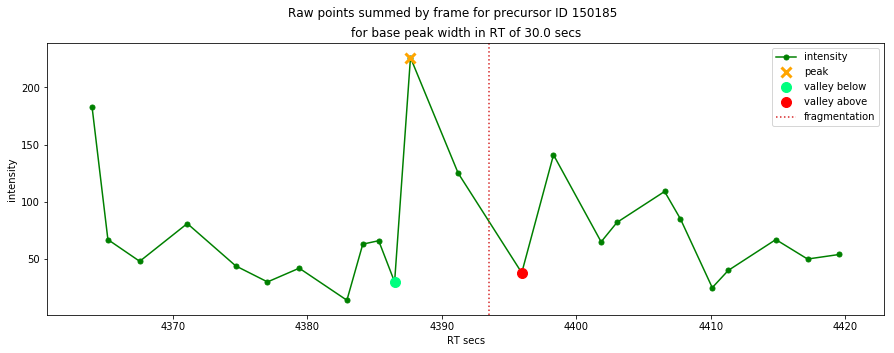

In [643]:
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='green', linestyle='-', ms=5)
ax.plot(peaks_df.retention_time_secs, peaks_df.intensity, marker='x', color='orange', linestyle='', markeredgewidth=3, ms=10, label='peak')
if valley_idx_below != -1:
    ax.plot(valleys_df.loc[valley_idx_below].retention_time_secs, valleys_df.loc[valley_idx_below].intensity, marker='o', color='springgreen', linestyle='', markeredgewidth=1, ms=10, label='valley below')
if valley_idx_above != -1:
    ax.plot(valleys_df.loc[valley_idx_above].retention_time_secs, valleys_df.loc[valley_idx_above].intensity, marker='o', color='red', linestyle='', markeredgewidth=1, ms=10, label='valley above')
plt.axvline(x=window_df.retention_time_secs, linestyle=':', color='tab:red', label='fragmentation')
plt.legend(loc='best')
plt.xlabel('RT secs')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by frame for precursor ID {}'.format(precursor_id))
plt.title('for base peak width in RT of {} secs'.format(RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()

Collapsing the summed points onto the mobility dimension

In [644]:
scan_df = monoisotopic_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_df

,scan,intensity
0,213,70
1,217,63
2,222,11
3,235,52
4,239,19
5,240,67
6,243,10
7,244,44
8,245,98
9,246,189


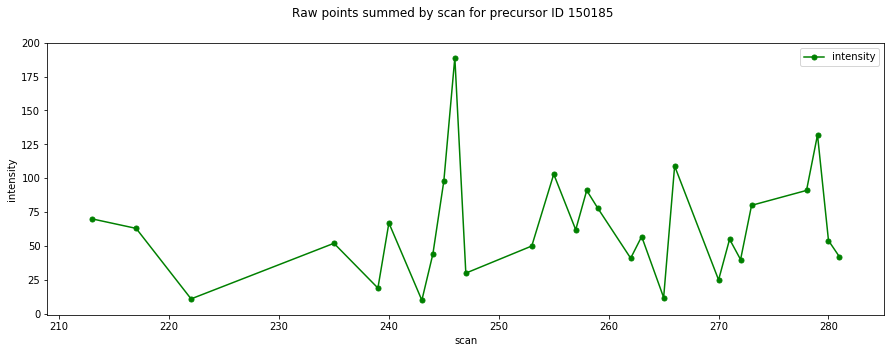

In [645]:
f, ax = plt.subplots()
ax.plot(scan_df.scan, scan_df.intensity, marker='o', color='green', linestyle='-', ms=5)
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by scan for precursor ID {}'.format(precursor_id))
# plt.title('RT width {} secs'.format(2*RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()